In [177]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from mne.preprocessing import ICA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline



In [3]:
def SubjFolderSearch(path):
    subjFolders = os.listdir(path)
    AllFolders = []
    for i in subjFolders:
        if '.DS_Store' not in i:
            AllFolders.append(i)
    
    AllFolders_dict = {}
    for eachFolder in AllFolders:
        eachFolderPath = os.path.join(path,eachFolder)
        folderContents = os.listdir(eachFolderPath)
        AllFolders_dict[eachFolder] = [file for file in folderContents if '.set' in file]
       
        
    return AllFolders_dict

In [4]:
#seach all folders and the set files in each folder
path = '/Volumes/flash32/EEGLAB'
AllSetFiles = SubjFolderSearch(path)
print(AllSetFiles)

{'SA20140304': ['20140304_1418.set', '20140304_1614.set'], 'SA20140306': ['20140306_1133.set', '20140306_1338.set']}


In [90]:
# read file
np.random.seed(42)
folder_keys = list(AllSetFiles.keys())      
folder = os.path.join(path,folder_keys[1])

set_file = os.path.join(folder, AllSetFiles[folder_keys[1]][1])
raw = mne.io.read_raw_eeglab(set_file, preload=True, verbose = True)
raw_copy = raw.copy().crop(10,300)

Reading /Volumes/flash32/EEGLAB/SA20140306/20140306_1338.fdt
Reading 0 ... 796266  =      0.000 ...  1555.207 secs...


In [167]:
events = mne.find_events(raw_copy,min_duration=1/raw.info['sfreq'], shortest_event=1)


1072 events found
Event IDs: [  1   2   3   4   5   7   8   9  10  11  13  14  19  20  21  31 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 157 158 159
 160 161 162 163 164]


In [93]:
event_id = {'TRIALSTART':31,
            'LEFTBUTTON':131, # only one button code is sent,
            'RIGHTBUTTON':132, # but it may appear before f2 stim if fast response
            'CONGRUENT':133,# only one congruity code is sent
            'INCONGRUENT':134,
            'CORRECT':129, # only one accuracy code is sent
            #'INCORRECT':130,
            #target
            'BABY_T':135, 
            'BELL_T':136,
            'BIRD_T':137, 
            'BURP_T':138, 
            'DOG_T':139, 
            'DRUM_T':140, 
            'KNOCK_T':141, 
            'LAUGH_T':142, 
            'PHONE_T':143, 
            'TRAIN_T':144,  
            'WATER_T':145,
            #flanker
            #'BABY_F':155, 
            #'BELL_F':156,
            'BIRD_F':157, 
            'BURP_F':158, 
            'DOG_F':159, 
            'DRUM_F':160, 
            'KNOCK_F':161, 
            'LAUGH_F':162, 
            'PHONE_F':163, 
            'TRAIN_F':164,  
            #'WATER_F':165,
            }

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1691 samples (3.303 sec) selected
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-257-df621bb466ad>:8: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epoch.average().plot()


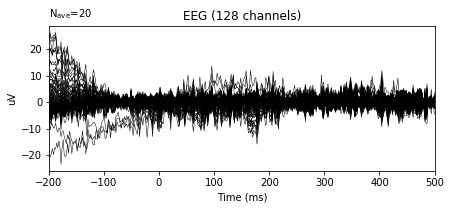

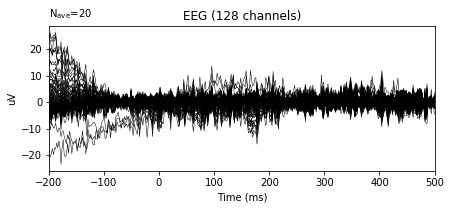

In [257]:
raw_copy.filter(1., None, n_jobs=1, fir_design='firwin')
tmin, tmax = -0.1, 0.3
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
epoch = mne.Epochs(raw_copy,events,event_id=[135,136],preload=True,picks=picks, baseline=None,
                    verbose=False)

epoch.average().plot()

In [288]:
X = epoch.get_data()
y=epoch.events[:,-1]

X[:,-1]

array([[-5.53499408e-05, -5.34037720e-05, -5.86036471e-05, ...,
         6.28996689e-06,  2.19822207e-06,  3.49364190e-06],
       [-7.73233107e-06, -2.16700854e-06,  4.24243931e-06, ...,
        -3.92754111e-06, -3.67611466e-06,  1.05828417e-07],
       [ 1.59053676e-06,  6.32415200e-06, -3.95831153e-06, ...,
        -2.43816397e-06,  3.09636244e-06,  4.17895256e-06],
       ...,
       [-8.25945974e-07, -7.84425244e-06,  1.05117196e-05, ...,
         1.74677360e-06, -4.77812100e-06, -5.33854416e-06],
       [-9.20635261e-07, -1.80138561e-06,  1.38975552e-06, ...,
        -8.52817696e-06, -8.73822618e-06, -3.07551494e-06],
       [-4.32348659e-05, -3.88729064e-05, -4.64228003e-05, ...,
        -8.47608223e-06, -4.99722706e-06, -1.31478321e-05]])

In [294]:
pca = UnsupervisedSpatialFilter(PCA(36), average=False)
pca_data = pca.fit_transform(X)



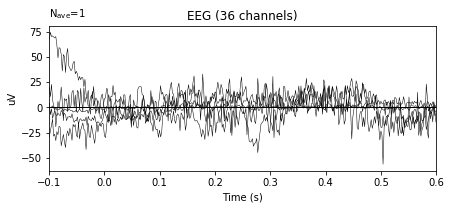

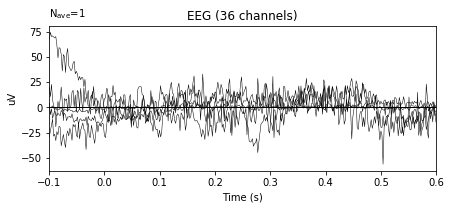

In [270]:
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(36, epoch.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')

In [291]:
#logic regres classification
logreg = LogisticRegression()

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
XX = X[:,-1]
#fit with cross validation on original data
preds = np.empty(len(y))
scores = []
for train, test, in cv.split(X, y):
    logreg.fit(XX[train], y[train])
#     preds[test] = clf.predict(X[test])
    scores.append(logreg.score(XX[test],y[test]))

In [292]:
print("mean classification score", np.mean(scores))



mean classification score 0.65


In [295]:
# classifiy with pca and logreg

pca_preds = np.empty(len(y))
pca_scores = []
X_pca = pca_data[:,-1]
for train, test, in cv.split(pca_data, y):
    logreg.fit(X_pca[train], y[train])
#     preds[test] = clf.predict(X[test])
    scores.append(logreg.score(X_pca[test],y[test]))


In [297]:
print("pca with 36 compoentns mean classification score", np.mean(scores))

pca with 36 compoentns mean classification score 0.575
